 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations.


## But first... Theory
Solve the theoretical problems. Type the solutions here, using Latex

### Problem 1 (2 points)

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

#### Solution

1. Применим паддинг к Х:
$        X = \begin{bmatrix}
        0 &0 & 0 & 0 & 0 & 0 \\
        0 &1 & 0 & -4 & 2 & 0 \\
        0 &5 & 2 & 3 & 0 & 0\\
        0 &-1 & 0 & 1 & 4 & 0\\
        0 & 0 & -3 & 2 & -1 & 0\\
        0 &0 & 0 & 0 & 0 & 0 
    \end{bmatrix}
$
2. Далее учитывая дилэйшн = 2 считаем поэлементное перемножение матриц и суммирование элементов:    
   $    
       \begin{bmatrix}
        X[0, 0] & X[0, 2] \\
        X[2, 0] & X[2, 2]
    \end{bmatrix} * K = 0*2 + 0*1 + 0*(-1) + 2*(-2) = -4
$
4. Далее смещаемся на 2 вправо ввиду страйд = 2:  
   $    
       \begin{bmatrix}
        X[0, 2] & X[0, 4] \\
        X[2, 2] & X[2, 4]
    \end{bmatrix} * K = 0*2 + 0*1 + 2*(-1) + 0*(-2) = -2
    $
6. Остальные 2 элемента итоговой матрицы:  
   $    
       \begin{bmatrix}
        X[2, 0] & X[2, 2] \\
        X[4, 0] & X[4, 2]
    \end{bmatrix} * K = 0*2 + 2*1 + 0*(-1) + (-3)*(-2) = 8
    $  
    $    
       \begin{bmatrix}
        X[2, 2] & X[2, 4] \\
        X[4, 2] & X[4, 4]
    \end{bmatrix} * K = 2*2 + 0*1 + (-3)*(-1) + (-1)*(-2) = 9
    $
8.  Итог:
   $    
       \begin{bmatrix}
        -4 & -2 \\
        8 & 9
    \end{bmatrix} 
    $

### Problem 2 (2 points)

Count the number of trainable params in nn:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

#### Solution

Начнем подсчет по слоям:
1. nn.Conv2d(
        in_channels=3, out_channels=16, kernel_size=5,
        stride=2, padding=0, dilation=1, bias=True
    )  
   $N_1 = Input * Output * Kernel**2 + Bias = 16*3*5*5 + 16 = 1216 $
2. nn.BatchNorm2d(16)  
   $N_2 = Scale + Shift  = 16 + 16 = 32 $
4. nn.LeakyReLU(0.1) - нетренируемый  
   $N_3 = 0 $
6. nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5,
            stride=1, padding=1, dilation=2, bias=False
        )  
    $N_4 = Input * Output * Kernel**2 = 32*16*5*5 = 12800 $
7. nn.BatchNorm2d(num_features=32)  
   $N_5 = Scale + Shift  = 32 + 32 = 64 $
8. nn.Sigmoid()- нетренируемый  
   $N_6 = 0 $
10. Итог: 1216 + 32 + 0 + 12800 + 64 + 0 = 14112

### Practical problem


Solve multicalss classification problem for Food101 dataset

####  Helper code

In [1]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from collections import Counter
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)  # Фиксируем seed для встроенного генератора Python
    np.random.seed(seed)  # Фиксируем seed для NumPy
    torch.manual_seed(seed)  # Фиксируем seed для PyTorch (CPU)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Фиксируем seed для PyTorch (CUDA)
        torch.cuda.manual_seed_all(seed)  # Фиксируем seed для всех доступных GPU
        torch.backends.cudnn.deterministic = True  # Гарантируем детерминированность CUDNN
        torch.backends.cudnn.benchmark = False  # Отключаем эвристику для оптимизации скорости

# Вызов функции для установки seed
set_seed(0x3df3fa)

In [4]:
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101")

filepath = os.path.join(dataset_directory, "food101.tar.gz")
download_url(
    url=url,
    filepath=filepath,
)
%time extract_archive(filepath)

food101.tar.gz: 100%|██████████| 4.65G/4.65G [03:56<00:00, 21.1MB/s]


CPU times: user 37.4 s, sys: 16.8 s, total: 54.2 s
Wall time: 54.3 s


### Dataloaders (1 point)

In [5]:
NUM_WORKERS = os.cpu_count()


def split_data(dataset, val_size=0.2, seed=42):
    """
    """
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data


def create_dataloaders(data_dir: str,
                       batch_size: int,
                       train_transforms: transforms.Compose,
                       test_transforms: transforms.Compose,
                       num_workers: int = 2):

    full_dataset = datasets.ImageFolder(root=data_dir)
    train_size = int(0.8 * len(full_dataset))
    test_and_unique_size = len(full_dataset) - train_size
    test_size = int(0.95 * test_and_unique_size)
    unique_size = test_and_unique_size - test_size

    train_dataset, test_and_unique_dataset = random_split(full_dataset, [train_size, test_and_unique_size])
    test_dataset, unique_dataset = random_split(test_and_unique_dataset, [test_size, unique_size])

    # Применяем правильные трансформации
    train_dataset.dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
    test_dataset.dataset = datasets.ImageFolder(root=data_dir, transform=test_transforms)
    unique_dataset.dataset = datasets.ImageFolder(root=data_dir, transform=test_transforms)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    unique_dataloader = DataLoader(unique_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    class_names = full_dataset.classes

    return train_dataloader, test_dataloader, unique_dataloader, class_names

In [6]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [7]:
from pathlib import Path

data_path = Path(dataset_directory)
image_path = data_path / "food-101" / "images"

Define transforms. You can add augmentations for better perfomance.

 You can either use Albumentation or torchvision

Don't forget to normalize images

In [8]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
batch_size = 32
num_workers = 2

 #### Train function (2 points)




In [10]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Initialize total loss and accuracy
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training Progress")):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Calculate accuracy
        y_pred_classes = y_pred.argmax(dim=1)  # Get predicted class indices
        total_correct += (y_pred_classes == y).sum().item()
        total_samples += y.size(0)

    # Compute average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    model.eval()
    
    loss_array = np.array([])
    accuracy_array = np.array([])

    with torch.no_grad(): 
        for x, y in tqdm(dataloader, desc="Test Progress"):
            x, y = x.to(device), y.to(device) 
            
            y_pred = model(x)
            
            # Compute loss
            loss = loss_fn(y_pred, y).item()
            loss_array = np.append(loss_array, loss)
            
            # Compute accuracy
            y_pred_classes = y_pred.argmax(dim=1) 
            accuracy = (y_pred_classes == y).sum().item() / len(y)
            accuracy_array = np.append(accuracy_array, accuracy)
    
    test_loss, test_acc = np.mean(loss_array), np.mean(accuracy_array)
    return test_loss, test_acc

In [11]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float, float]:
    """Tests a PyTorch model for a single epoch and calculates accuracy on the most frequent class.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of:
    - testing loss
    - overall testing accuracy
    - accuracy on the most frequent class
    """

    model.eval()
    
    loss_array = np.array([])
    accuracy_array = np.array([])
    
    all_targets = []
    all_preds = []

    with torch.no_grad(): 
        for x, y in tqdm(dataloader, desc="Test Progress"):
            x, y = x.to(device), y.to(device) 
            
            y_pred = model(x)
            
            # Compute loss
            loss = loss_fn(y_pred, y).item()
            loss_array = np.append(loss_array, loss)
            
            # Compute accuracy
            y_pred_classes = y_pred.argmax(dim=1) 
            accuracy = (y_pred_classes == y).sum().item() / len(y)
            accuracy_array = np.append(accuracy_array, accuracy)

            # Store predictions and targets
            all_targets.extend(y.cpu().numpy())
            all_preds.extend(y_pred_classes.cpu().numpy())

    # Find the most frequent class in the dataset
    most_common_class, _ = Counter(all_targets).most_common(1)[0]

    # Compute accuracy for the most frequent class
    most_common_correct = sum(
        1 for pred, target in zip(all_preds, all_targets) if target == most_common_class and pred == target
    )
    most_common_total = sum(1 for target in all_targets if target == most_common_class)
    most_common_acc = most_common_correct / most_common_total if most_common_total > 0 else 0.0
    test_loss, test_acc = np.mean(loss_array), np.mean(accuracy_array)
    return test_loss, test_acc, most_common_acc

In [12]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          unfreeze_epoch: int = 10) -> Dict[str, List]:
    
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)
    
    best_test_loss = float('inf')
    patience = 5
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc="Epoch"):
        # Размораживаем backbone на указанной эпохе
        if epoch == unfreeze_epoch:
            unfreeze_backbone(model, optimizer)
        
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc, most_common_acc = test_step(model, test_dataloader, loss_fn, device)
        
        scheduler.step()
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f} | "
              f"most_common_accuracy: {most_common_acc:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Ранняя остановка
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return results

Choose a model

In [13]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


Froze several layers or tune whole model

In [14]:
def unfreeze_backbone(model, optimizer):
    # Размораживаем все параметры
    for param in model.parameters():
        param.requires_grad = True
    
    # Добавляем параметры backbone (кроме fc) с новым LR
    backbone_params = []
    for name, param in model.named_parameters():
        if 'fc' not in name:
            backbone_params.append(param)
    
    optimizer.add_param_group({'params': backbone_params, 'lr': 1e-5})


# Инициализация модели и оптимизатора
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)
for param in model.fc.parameters():
    param.requires_grad = True

Model summary

In [15]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 101]            --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### Train (1 point)

In [16]:
# Определяем функцию потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 2

In [17]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101")

# Проверяем, что внутри
print(os.listdir(dataset_directory))

['food101.tar.gz', 'food-101']


In [18]:
dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101", "food-101")
data_dir = os.path.join(dataset_directory, "images")  # Папка с изображениями

train_dataloader, test_dataloader, unique_dataloader, class_names = create_dataloaders(
    data_dir=data_dir, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    batch_size=8,
    num_workers=NUM_WORKERS
)

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
# Запуск обучения
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn=loss_fn,
                epochs=20,
                device=device,
                unfreeze_epoch=10
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1409 | train_acc: 0.2741 | test_loss: 2.5070 | test_acc: 0.3822 | most_common_accuracy: 0.4885


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        if w.is_alive():
self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

Exception ignored in:   File "/usr/lib/python3.10/multiprocessi

Epoch: 2 | train_loss: 2.6990 | train_acc: 0.3550 | test_loss: 2.5992 | test_acc: 0.3809 | most_common_accuracy: 0.6990


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>

Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]


Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

self._shutdown_workers()    Traceback (most recent call last):

self._shutdown_workers()Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.6354 | train_acc: 0.3722 | test_loss: 2.6449 | test_acc: 0.3649 | most_common_accuracy: 0.6708


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 2.5898 | train_acc: 0.3815 | test_loss: 2.3836 | test_acc: 0.4391 | most_common_accuracy: 0.6667


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 2.5499 | train_acc: 0.3879 | test_loss: 2.4865 | test_acc: 0.4074 | most_common_accuracy: 0.5771


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 2.4281 | train_acc: 0.4144 | test_loss: 2.1196 | test_acc: 0.4716 | most_common_accuracy: 0.6375


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 2.4049 | train_acc: 0.4182 | test_loss: 2.2970 | test_acc: 0.4338 | most_common_accuracy: 0.6375


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 2.3908 | train_acc: 0.4208 | test_loss: 2.0725 | test_acc: 0.4825 | most_common_accuracy: 0.6937


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 2.3808 | train_acc: 0.4223 | test_loss: 2.3345 | test_acc: 0.4306 | most_common_accuracy: 0.7031


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 10 | train_loss: 2.3712 | train_acc: 0.4256 | test_loss: 2.2166 | test_acc: 0.4535 | most_common_accuracy: 0.6406


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    
  File "/usr/loc

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 1.9786 | train_acc: 0.5127 | test_loss: 1.3932 | test_acc: 0.6404 | most_common_accuracy: 0.8229


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 1.6748 | train_acc: 0.5775 | test_loss: 1.2525 | test_acc: 0.6790 | most_common_accuracy: 0.8677


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>Traceback (most recent call last):

assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
AssertionEr

Epoch: 13 | train_loss: 1.5212 | train_acc: 0.6156 | test_loss: 1.1106 | test_acc: 0.7095 | most_common_accuracy: 0.7688


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 1.4205 | train_acc: 0.6390 | test_loss: 1.0444 | test_acc: 0.7244 | most_common_accuracy: 0.8792


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 1.3378 | train_acc: 0.6557 | test_loss: 0.9288 | test_acc: 0.7529 | most_common_accuracy: 0.9177


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30><function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/tor

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:         <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>if w.is_alive():assert self._parent_pid == os.getpid(), 'can on

Epoch: 16 | train_loss: 1.2045 | train_acc: 0.6895 | test_loss: 0.8404 | test_acc: 0.7784 | most_common_accuracy: 0.9198


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 1.1584 | train_acc: 0.7003 | test_loss: 0.7522 | test_acc: 0.8019 | most_common_accuracy: 0.9365


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 1.1216 | train_acc: 0.7088 | test_loss: 0.7576 | test_acc: 0.7976 | most_common_accuracy: 0.9177


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()Exception ignored in:     Exception ignored in: Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d95a8c00d30>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIte

Epoch: 19 | train_loss: 1.1033 | train_acc: 0.7127 | test_loss: 0.7149 | test_acc: 0.8050 | most_common_accuracy: 0.9281


Training Progress:   0%|          | 0/10100 [00:00<?, ?it/s]

Test Progress:   0%|          | 0/2399 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 1.0633 | train_acc: 0.7230 | test_loss: 0.6752 | test_acc: 0.8165 | most_common_accuracy: 0.9021
[INFO] Total training time: 15987.602 seconds


### Results (2 points in total)
Plot train and val losses

Inference model on unique subset of images


It must be very obvious that you specificaly using images that model has never seen neither during training nor evaluation steps




In [21]:
test_step(model=model,dataloader=unique_dataloader, loss_fn=loss_fn, device=device)

Test Progress:   0%|          | 0/127 [00:00<?, ?it/s]

(0.7426942903841809, 0.8139763779527559, 0.6833333333333333)

#### Graphs (1 point)
Plot graphs for train and val loss



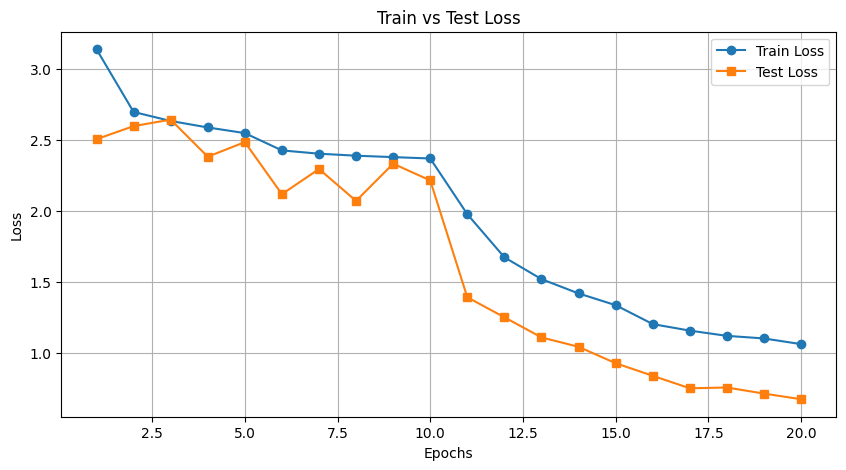

In [22]:
epochs = range(1, len(results["train_loss"]) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, results["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs, results["test_loss"], label="Test Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

#### Demonstration (1 point)

Show model prediction on several images

In [23]:
def predict_images(model, images, class_names, true_labels=None):
    model.to(device)
    model.eval()

    num_images = len(images)
    rows = 2
    cols = (num_images + 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, img_tensor in enumerate(images):
        img_tensor = img_tensor.to(device)  # Перемещаем на GPU (если доступен)
        mean, std = mean.to(img_tensor.device), std.to(img_tensor.device)  # Делаем mean/std на том же устройстве
        
        # Предсказание модели
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))  # Добавляем batch размерность
            output = torch.nn.functional.softmax(output, dim=1)
            pred_class = torch.argmax(output, dim=1).item()

        # Получаем истинный класс
        if true_labels is not None:
            true_class = true_labels[i].item()
            color = "green" if pred_class == true_class else "red"
            title_text = f"Pred: {class_names[pred_class]} (True: {class_names[true_class]})"
        else:
            color = "black"
            title_text = f"Predicted: {class_names[pred_class]}"

        # Денормализация изображения
        img_tensor = img_tensor.cpu() * std.cpu() + mean.cpu()  # Обратно из нормализованного диапазона
        img_tensor = torch.clamp(img_tensor, 0, 1)  # Ограничиваем диапазон [0,1]
        image = img_tensor.permute(1, 2, 0).cpu().numpy()  # Переставляем оси для matplotlib

        axes[i].imshow(image)
        axes[i].set_title(title_text, fontsize=10, color=color)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):  # Отключаем лишние оси
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [24]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

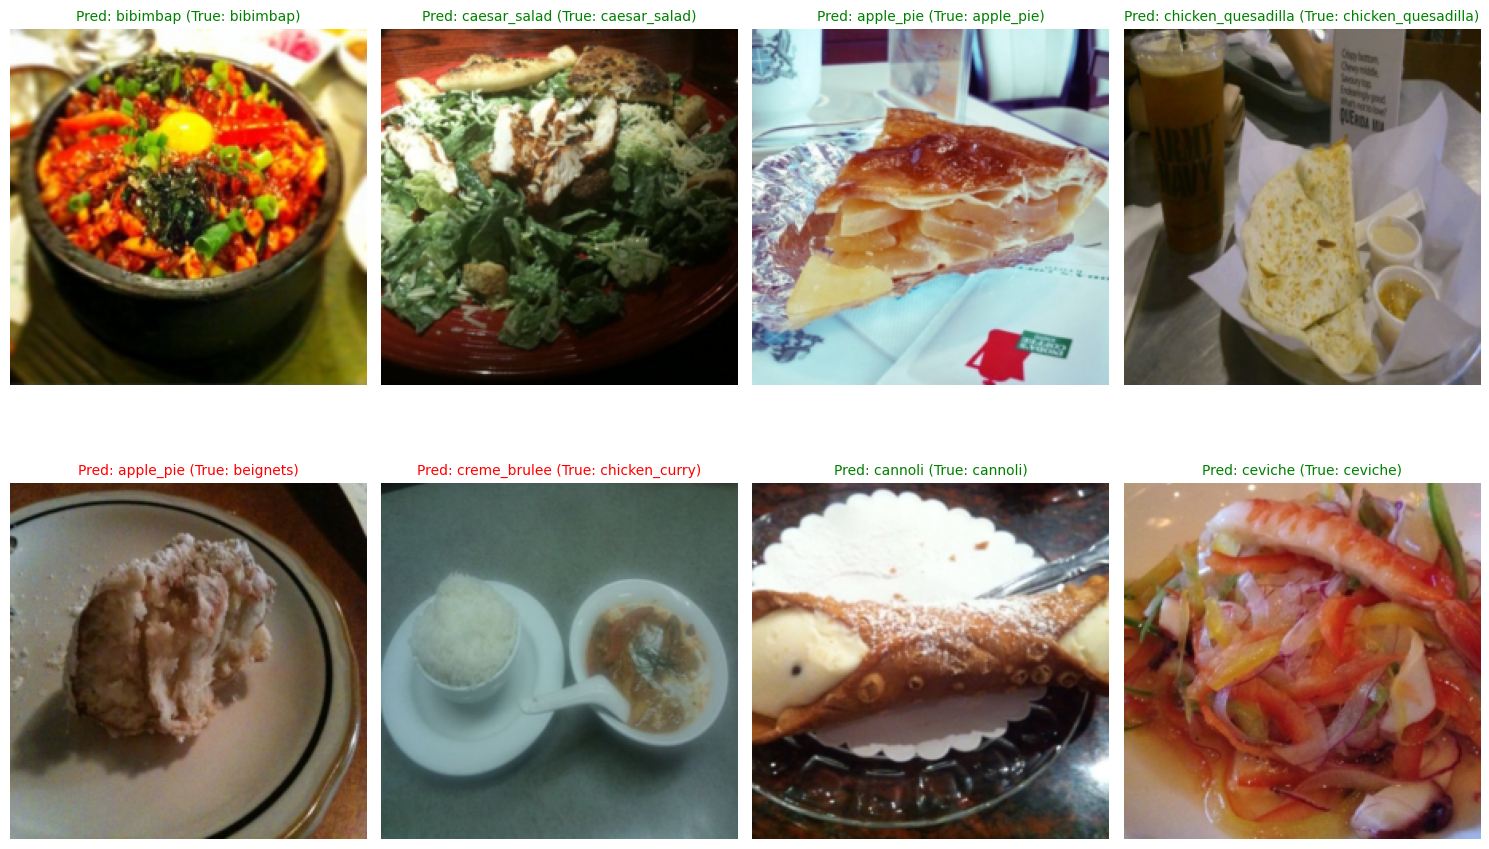

In [25]:
test_iter = iter(unique_dataloader)
test_images, test_labels = next(test_iter)  # Получаем batch с истинными метками

predict_images(model, test_images, class_names, test_labels)